# Competencia: Santander Customer Satisfaction

Desde los cargos de atención al cliente, hasta en los cargos directivos la satisfacción del cliente es una de las principales métricas de éxito. Los clientes insatisfechos no se mantienen por mucho tiempo, y mas aún, los clientes insatisfechos no demuestran su insatisfacción sino hasta que ya han dejado la compañia.

El Banco Santander le esta solciitando a la comunidad de Kaggle que le ayude a identificar a los clientes insatisfechos en una etapa temprana de la relación comercial. Hacerlo le permitirá a Santander tomar medidas preventivas para mejorar la satisfacción de sus clientes antes de que sea demasiado tarde.

En esta competencia usted trabajrá con cientos de características anonimizadas para predecir si un cliente está o no satisfecho con su experiencia bancaria.

## Grupo de trabajo

- John Franklin Gonzalez Gamboa - 201725981
- Jorge Eduardo Rodriguez Cardozo - 200711501
- German Augusto Carvajal Murcia - 201313516

## Acceso a la base de datos

Se ejecuta el siguiente comando dentro un la consola/terminal del equipo para acceder a la base de datos del proyecto:

- Pre-condición: La API de Kaggle se encuentra instalada y configurada. Se han aceptado los terminos y condiciones del acceso a la base de datos de la competencia

- Post-condición: La base de datos es descargada a la ubicación especificada

`kaggle competitions download -c santander-customer-satisfaction --path .../Santander`

## Carga de la información

El proceso de análisis de la información disponible inicia especificando la ruta de trabajo y repositorio de archivos dentro del cual se almacenarán todos aquellos resultados del proceso. Por defecto se establece que la dirección de almacenamiento de este documento, correponde a la misma que la carpeta `Santander` dentro de la cual se ubicaron los archivos.

In [1]:
import os
os.chdir(os.getcwd()+'/Santander')

Una vez descargados localmente los archivos de la competencia, la base de datos de entrenamiento se carga a la memoria para inciar el proceso de limpieza. Asimismo, se importan las librerias y funciones de dispositovs gráficos necesarios para realizar la lectura, limpieza y visualización de los datos.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)
import zipfile
Data_train = zipfile.ZipFile('../Santander/train.csv.zip', 'r').open('train.csv')
Data_train = pd.io.parsers.read_table(Data_train, sep=',')
Data_train = Data_train.loc[:,Data_train.columns!='ID']

La base de datos disponible para el entrenamiento tiene un total de 76020 registros y 369 caracteristicas individuales adicionales a la variable dependiente del modelo.

In [3]:
Data_train.shape

(76020, 370)

La sabana de registros corresponde a un corte transversal de los clientes del banco, dónde la variable de interés es categórica binaria clasificando a los individuos en satisfechos e insatisfechos. En cuanto a las demás caracteristicas, todas se presentan de forma numérica. A pesar que casi toda ellas se registran con valores enteros, no es posible determinar cuales de ellas corresponden a categorías o conteos debido a la anonimización de las variables.

## Limpieza de la base de datos de entrenamiento

El proceso de limpieza de datos se sustentará en el desarrollo realizado por Lode Nachtergaele AKA: [cast42](https://www.kaggle.com/cast42) (2015) como parte de la competencia abierta de Kaggle. De este modo, se inicia el proceso de limpieza con la identificación de valores invalidos con magnitudes positivas alejadas de la escala normal de las demás variables, o con registros negativos que no corresponden con la naturaleza de las variables.

In [4]:
print("Valores extremos","\t","Total de valores extremos")
print(Data_train.values.min(),"\t\t",Data_train.stack()[Data_train.stack().values==Data_train.values.min()].count())
print(Data_train.values.max(),"\t\t",Data_train.stack()[Data_train.stack().values==Data_train.values.max()].count())

Valores extremos 	 Total de valores extremos
-999999.0 		 116
9999999999.0 		 1194


Se procede con la eliminación de los valores invalidos, los cuales se supone corresponde a valores erroneamente registrados que serán tomados como datos faltantes dentro de la base de datos. Siguiendo este procedimiento se reemplazan 1130 valores invalidos y que no correponden con la naturaleza de las variables usadas.

In [5]:
Data_train=Data_train.replace(-999999.0,float('NaN'))
Data_train=Data_train.replace(9999999999.0,float('NaN'))

A continuación, se procede a verificar y eliminar todas aquellas caracteristicas cuya variabilidad sea nula. Lo anterior, debido a que no aportarán nueva información al modelo construido y no permitirán clasificar la satisfacción de los clientes puesto que no existen cambios en sus valores a través de la muestra de individuos. Aplicando este criterio se remueven 44 caracteristicas individuales, reteniendo 326 variables dentro de la base de datos.

In [6]:
print("Variables con varianza 0: ",(Data_train.var(axis=0)==0).sum())
Data_train=Data_train.loc[:,(Data_train.var(axis=0)!=0)]
print("Variables despues de la eliminación: ", Data_train.shape[1])

Variables con varianza 0:  44
Variables despues de la eliminación:  326


## Valores faltantes en la base de entrenamiento

Habiendo realizado la eliminación de los valores erroneos y de las caracterisicas constantes, se procede a realizar la revisión del comportamiento de los valores faltantes existentes dentro de la bse de datos. A continuación, se presenta un mapa de faltantes en el cual se evidencia que la base de datos cuenta con valores en  el 99.996% de sus campos.

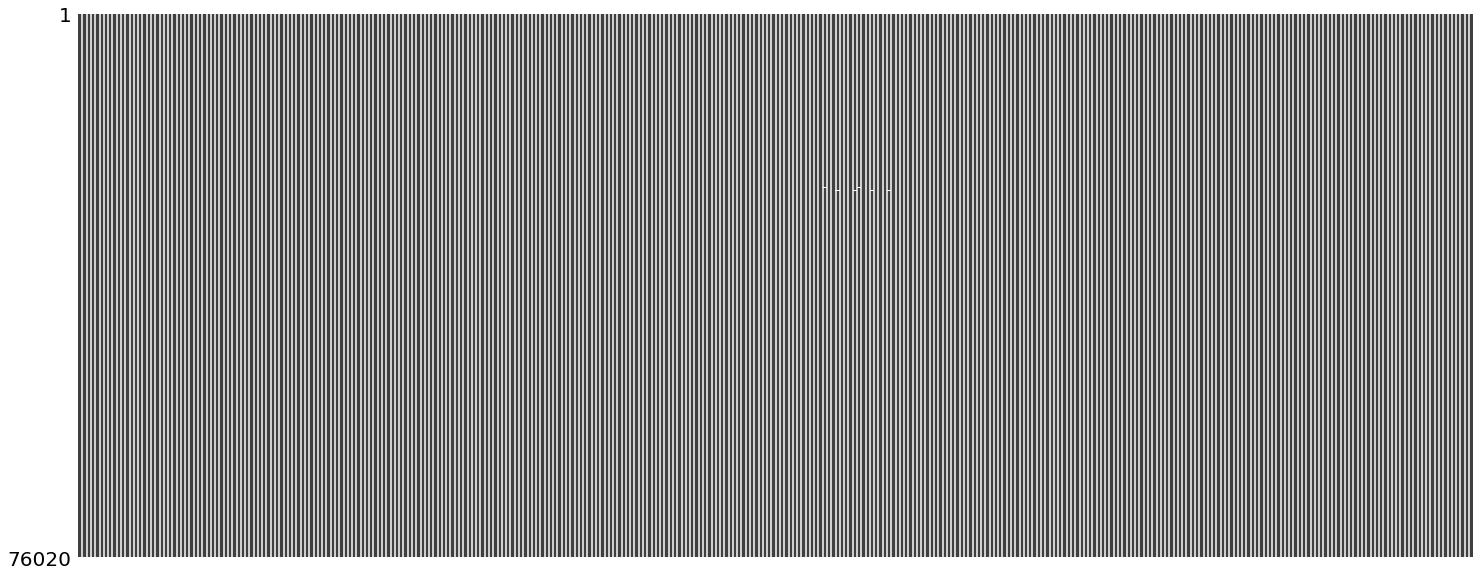

In [7]:
import missingno as msno
msno.matrix(Data_train,n=76020,sparkline=False)

En cuanto al comportamiento de campos nulos para cada registro, se identifca que de los 76020 individuos, 75402 contienen valores para la totalidad de las caracteristicas, sólo 618 presentan entre 1 y 6 valores faltantes, lo cual representa el 0.81% de la muestra.

Miss Count
0    75402
2    454  
1    116  
4    47   
6    1    
Name: 0, dtype: int64


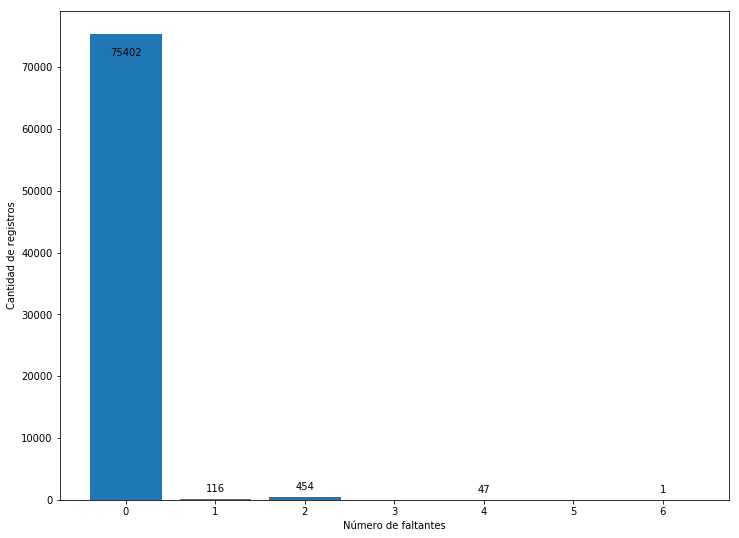

In [8]:
def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()

        # Fraction of axis height taken up by this rectangle
        p_height = (height / y_height)

        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column.
        if p_height > 0.95: # arbitrary; 95% looked good to me.
            label_position = height - (y_height * 0.05)
        else:
            label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                '%d' % int(height),
                ha='center', va='bottom')
        
plt.rcParams["figure.figsize"] = [12,9]
h=pd.DataFrame(Data_train.isnull().sum(axis=1)).sort_values(0,ascending=False)
print("Miss Count")
print(h[0].value_counts())
fig,ax=plt.subplots()
m=ax.bar(h[0].value_counts().index.values,h[0].value_counts())
plt.ylabel('Cantidad de registros')
plt.xlabel('Número de faltantes')
autolabel(m,ax)

Seguidamente, se realiza la detección de las variables con campos vacios y la frecuencia dentro de cada una de ellas, encontrandose que las caracteristicas `delta_imp_aport_var13_1y3` y `delta_num_aport_var13_1y3` son las de mayor relevancia con 370 (0.84% de la muestra) valores nulos cada una; seguido de la variable `var3` que cuenta con 116 campos vacios. Por otro lado, las restantes 14 variables con valores perdidos cuentan con entre 1 (0.001%) y 70 (0.09%) campos sin ningun valor.

In [9]:
h=pd.DataFrame(Data_train.isnull().sum()).sort_values(0,ascending=False)
varMis=h[h[0]>0].index
h[h[0]>0]

,0
delta_num_aport_var13_1y3,370
delta_imp_aport_var13_1y3,370
var3,116
delta_imp_compra_var44_1y3,70
delta_num_compra_var44_1y3,70
delta_num_venta_var44_1y3,42
delta_imp_venta_var44_1y3,42
delta_num_aport_var17_1y3,39
delta_imp_aport_var17_1y3,39
delta_num_reemb_var17_1y3,20


A partir de lo anterior, se identifica un comportamiento condicional en el cual siempre concide la perdida de los campos `*_imp_*` y `*_num_*` de las caracteristicas, indicando que algunas de estas variables corresponden a transformaciones. A traves de un mapa da calor de las correlaciones de las variables faltantes se confirma la relación existente entre los pares de variables `*_imp_*` y `*_num_*`, las cuales en todos los casos se presentan registradas o nulas de foma conjunta.

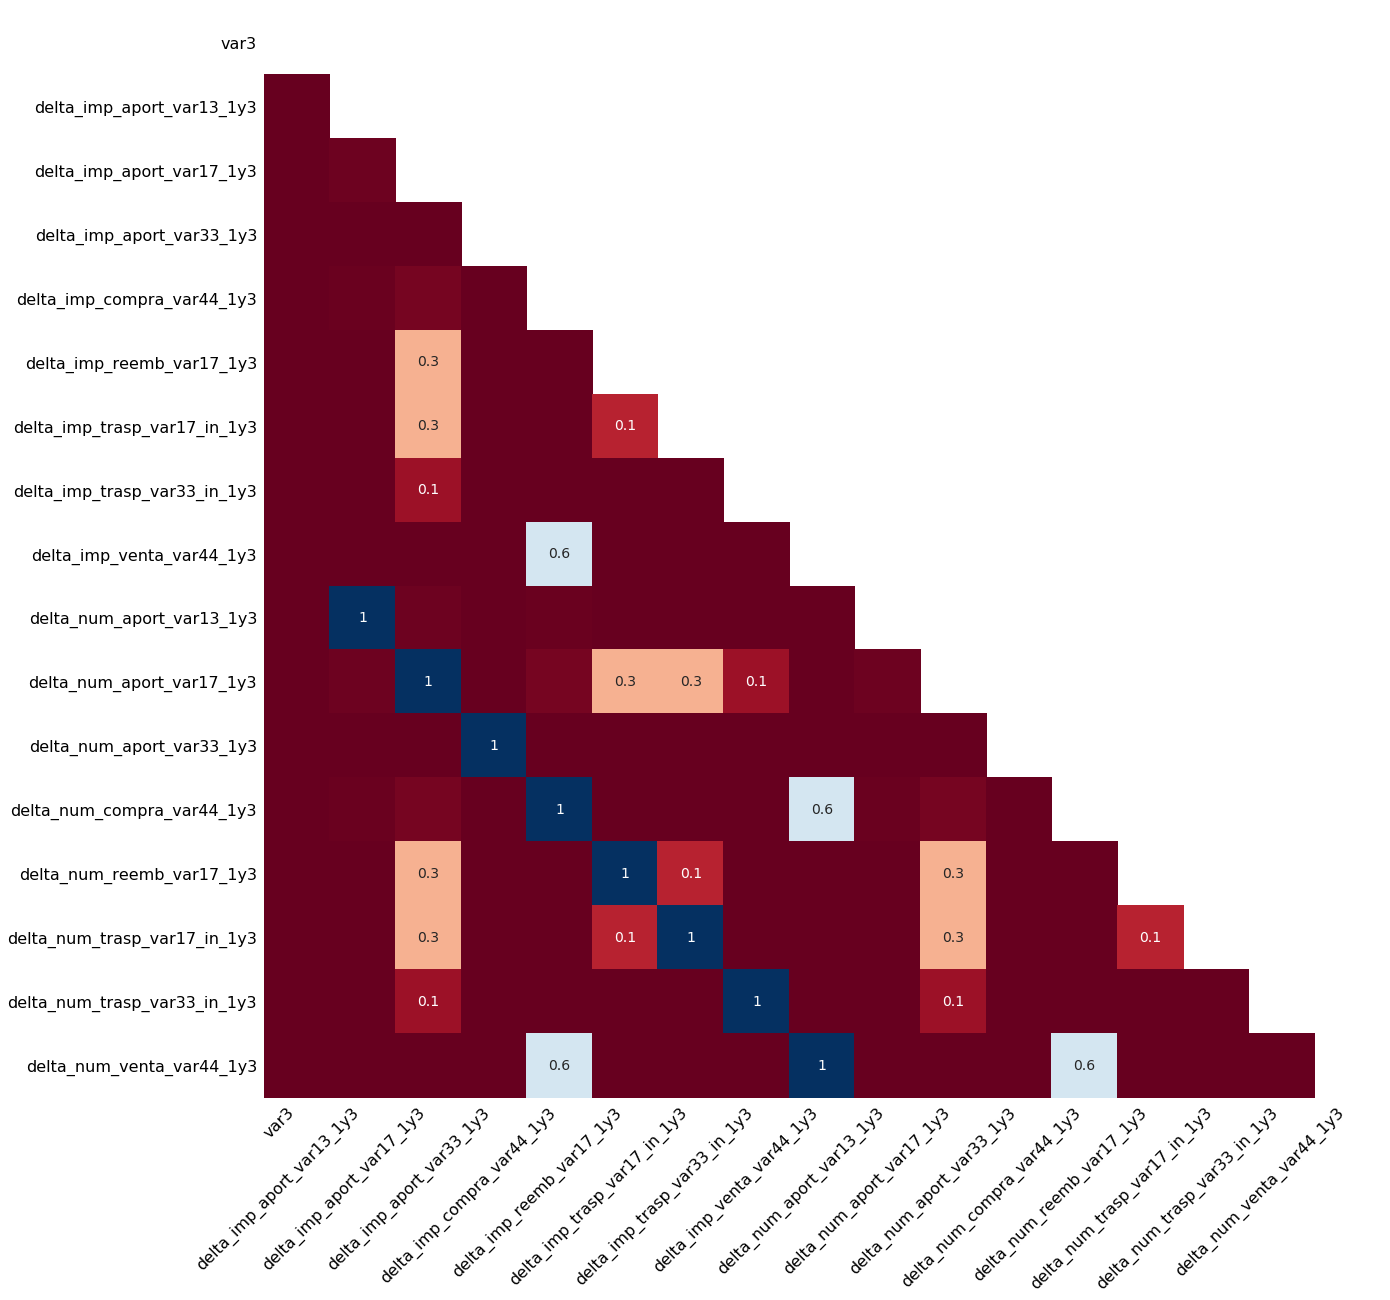

In [10]:
msno.heatmap(Data_train, figsize=(20,20))

Con el fin de verificar el tipo de proceso de generación de datos perdidos y la información diponible dentro de las demás variables de la base de datos, se realiza un estudio de correlaciones. Considerando la naturaleza numérica y parcilamente oculta de las caracteristicas, se opta por utilizar la correlacion de Pearson para computar la asociatividad entre variables. La siguiente tabla presenta la matriz de correlaciones filtrada donde las filas corresponden a todas aquellas variables con por lo menos un campo perdido, y en sus columnas se encuentran las variables completas (sin faltantes) con las cuales existe por lo menos una correlación con un valor superior a 0.5. Se resaltan las correlaciones que cumplen dicho criterio.

In [11]:
corr=Data_train.corr()
def highlight_corr(s):
    h = s.values>=0.5
    return ['background-color: yellow' if v else '' for v in h]
np.round(corr.loc[varMis,corr.columns[([h not in varMis for h in corr.columns])&(corr.loc[varMis,:].max()>=0.5)]],decimals=2).style.apply(highlight_corr)

,imp_compra_var44_ult1,imp_venta_var44_ult1,num_compra_var44_ult1,num_venta_var44_ult1
delta_num_aport_var13_1y3,0,0,-0,0
delta_imp_aport_var13_1y3,0,0,-0,0
var3,-0,-0,0,0
delta_imp_compra_var44_1y3,0.52,0.62,0.58,0.57
delta_num_compra_var44_1y3,0.46,0.53,0.7,0.62
delta_num_venta_var44_1y3,-0.02,-0.06,0.49,0.98
delta_imp_venta_var44_1y3,-0.02,-0.09,0.48,0.96
delta_num_aport_var17_1y3,0,0,0,0
delta_imp_aport_var17_1y3,0,0,0,0
delta_num_reemb_var17_1y3,0,0,0,0


Considerando los bajos valores de las correlaciones de la mayoria de las variables faltantes con las demás caracteristicas, se sugiere que no existe sufiente relación entre las variables como para inferir los valores de los campos vacios. Simultaneamente, para estas variables con aparente independencia no se identifica un patron de los campos perdidos y los valores de las demás variables, con lo cual se postula que estos se derivan de un proceso missing-completely-at-random (MCAR) y por tanto su imputación podría hacerse inclusive con valores completamente aleatorios.

Por otro lado, para las 4 variables en filas con campos resaltados, se identifican fuertes relaciones con otras caracteristicas de la base de datos y por tanto es posible inferir el valor esperado de los campos vacios a partir de los demás valores registrados. Para realizar la imputación se extraen las 8 caracteristicas adecuadas y se completa la matriz con el método MICE (multiple imputation by chained equations) basado en modelos de regresión.

In [12]:
var_impute=corr.columns[([h not in varMis for h in corr.columns])&(corr.loc[varMis,:].max()>=0.5)].union(['delta_num_compra_var44_1y3','delta_imp_compra_var44_1y3','delta_num_venta_var44_1y3','delta_imp_venta_var44_1y3'])
to_impute=Data_train[var_impute]
import fancyimpute
imputed=pd.DataFrame(fancyimpute.MICE(verbose=False).complete(to_impute))
imputed.columns=var_impute
Data_train[var_impute]=imputed

/Users/germancarvajal/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Una ves completadas las caracteristicas que siguen el proceso MAR, quedan 13 variables con datos faltantes derivadas de un proceso MCAR para el cual no es posible realizar una imputación confiable.

In [13]:
h=pd.DataFrame(Data_train.isnull().sum()).sort_values(0,ascending=False)
varMis=h[h[0]>0].index
h[h[0]>0]

,0
delta_imp_aport_var13_1y3,370
delta_num_aport_var13_1y3,370
var3,116
delta_num_aport_var17_1y3,39
delta_imp_aport_var17_1y3,39
delta_imp_reemb_var17_1y3,20
delta_num_reemb_var17_1y3,20
delta_num_trasp_var33_in_1y3,5
delta_imp_trasp_var33_in_1y3,5
delta_num_trasp_var17_in_1y3,4


Sin embargo, antes de proceder a la eliminación de los registros, a partir de la matríz de correlación se identifican algunos pares de variables para los cuales sólo existen valores numéricos en los individuos que no tienen sus caracteriscas completamente definidas. La siguiente tabla presenta las variables con datos faltantes, la frecuencia de los campos vacios en la columna y las caracteristicas que quedarían sin variabilidad al eliminar los registros.

In [14]:
h=corr.isnull().sum()
h=pd.DataFrame(h[h[0:]>0])
h['Variables']=[','.join(list(corr.loc[i][corr.loc[i].isnull()].index)) for i in h.index]
h

,0,Variables
delta_imp_aport_var17_1y3,4,"imp_trasp_var17_in_ult1,imp_trasp_var33_out_ult1,num_trasp_var17_in_ult1,num_trasp_var33_out_ult1"
delta_imp_reemb_var17_1y3,4,"imp_reemb_var17_ult1,imp_trasp_var17_out_ult1,num_reemb_var17_ult1,num_trasp_var17_out_ult1"
delta_imp_trasp_var17_in_1y3,2,"imp_trasp_var17_in_ult1,num_trasp_var17_in_ult1"
delta_imp_trasp_var33_in_1y3,4,"imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,num_trasp_var33_in_ult1,num_trasp_var33_out_ult1"
delta_num_aport_var17_1y3,4,"imp_trasp_var17_in_ult1,imp_trasp_var33_out_ult1,num_trasp_var17_in_ult1,num_trasp_var33_out_ult1"
delta_num_reemb_var17_1y3,4,"imp_reemb_var17_ult1,imp_trasp_var17_out_ult1,num_reemb_var17_ult1,num_trasp_var17_out_ult1"
delta_num_trasp_var17_in_1y3,2,"imp_trasp_var17_in_ult1,num_trasp_var17_in_ult1"
delta_num_trasp_var33_in_1y3,4,"imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,num_trasp_var33_in_ult1,num_trasp_var33_out_ult1"
imp_reemb_var17_ult1,2,"delta_imp_reemb_var17_1y3,delta_num_reemb_var17_1y3"
imp_trasp_var17_in_ult1,4,"delta_imp_aport_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_num_aport_var17_1y3,delta_num_trasp_var17_in_1y3"


Para ejemplificar la situación, la siguinte tabla corresponde al caso de la caracteristica con faltantes `delta_imp_aport_var17_1y3` y la variable `imp_trasp_var17_in_ult1`. Como puede verse, la totalidad de individuos con valores diferentes de 0 para `imp_trasp_var17_in_ult1` contienen faltantes y port tanto serían eliminados al desechar los registros incompletos.

In [15]:
Data_train[["delta_imp_aport_var17_1y3","imp_trasp_var17_in_ult1","TARGET"]][Data_train.imp_trasp_var17_in_ult1>0]

,delta_imp_aport_var17_1y3,imp_trasp_var17_in_ult1,TARGET
934,NaN,14356.26,0
28476,NaN,2999.82,0
50200,NaN,39927.15,0
67348,NaN,133730.58,0


Considerando esta limitación, la gran dimensionalidad del problema y el proceso de generación MCAR, se toma la decisión de realizar la eliminación incondicional de los 540 registros incompletos asi como de las 10 variables que permaneciarián dentro de la base de datos pero con varianza nula.

In [16]:
Data_train=Data_train.dropna()
print('Total de datos faltantes tras la eliminación: ',Data_train.isnull().sum().sum())
print("Variables con varianza 0: ",(Data_train.var(axis=0)==0).sum())
Data_train=Data_train.loc[:,(Data_train.var(axis=0)!=0)]
print("Variables despues de la eliminación: ", Data_train.shape[1])

Total de datos faltantes tras la eliminación:  0
Variables con varianza 0:  10
Variables despues de la eliminación:  316


Finalmente, se tiene una base de datos completa de 75480 registros individuales y 316 caracteristicas independientes que pueden utilizarse para predecir la satisfacción de los clientes. A continuación se presenta la tabla de resumen de medidas del comportamiento de los datos. Debido a que se identifican comportamientos extremos en muchas variables (valores de 0 en aproximadamente el 75% de los datos y un máximo de gran magnitud) el siguiente paso del proceso de análisis corresponderá a estudiar la presencia de valores atípicos dentro de la muestra.

In [17]:
Data_train.describe()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var39,ind_var44_0,ind_var44,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var17_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var33_in_1y3,delta_num_venta_var44_1y3,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var33_in_hace3,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_aport_var33_hace3,num_aport_var33_ult1,num_var7_emit_ult1,num_var7_recib_ult1,num_compra_var44_hace3,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var13_medio_ult3,num_meses_var17_ult3,num_meses_var29_ult3,num_meses_var33_ult3,num_meses_var39_vig_ult3,num_meses_var44_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_co

Dada por terminada la etapa de limpieza, se exporta la base de datos para preceder con el estudio de valores atípicos y demás etapas del proyecto.

In [18]:
Data_train.to_csv('Data_train.csv', index=False)